In [20]:
import pandas as pd

In [21]:
crime = pd.read_csv("crime_weather_preprocessed")
print(crime.columns)
print(crime.shape[0])

Index(['dow', 'hour_of_day', 'offense_date', 'temp_max', 'temp_min',
       'daylight_duration', 'precipitation_sum', 'precipitation_hours',
       'extracted_month', 'extracted_day', 'ucr_desc_numeric',
       'offense_year_numeric', 'time_block_numeric', 'census_tract_numeric',
       'census_block_numeric'],
      dtype='object')
360042


In [22]:
crime['offense_date'] = pd.to_datetime(crime['offense_date'], errors='coerce')

crime.set_index('offense_date', inplace=True)

In [23]:
crime_time_series = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).agg({
    'dow': 'mean',  
    'hour_of_day': 'mean',
    'extracted_month': 'mean',
    'extracted_day': 'mean',
    'temp_max': 'mean',
    'temp_min': 'mean',
    'daylight_duration': 'mean',
    'precipitation_sum': 'mean',
    'precipitation_hours': 'mean',
    'time_block_numeric': 'mean'
}).reset_index()

crime_time_series['Crime_Count_W'] = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).size().values

crime_time_series_seq = crime_time_series.sort_values(by='offense_date')

crime_time_series = crime_time_series.drop(columns=['offense_date'])

crime_time_series

,census_block_numeric,dow,hour_of_day,extracted_month,extracted_day,temp_max,temp_min,daylight_duration,precipitation_sum,precipitation_hours,time_block_numeric,Crime_Count_W
0,0,3.612903,10.774194,1.000000,3.419355,14.012673,2.872995,33396.085874,0.036132,8.258065,1.225806,62
1,0,3.931818,13.840909,1.000000,10.727273,39.481495,25.380132,33891.959251,0.225304,8.454545,1.000000,44
2,0,3.800000,14.171429,1.000000,18.028571,33.977197,18.672054,34573.083036,0.036670,4.057143,0.800000,35
3,0,4.017857,12.696429,1.000000,24.625000,46.487669,32.168027,35307.395717,0.092238,7.750000,1.178571,56
4,0,4.780488,11.317073,1.658537,11.878049,33.318698,17.041868,36302.567645,0.059823,7.024390,1.268293,41
...,...,...,...,...,...,...,...,...,...,...,...,...
33332,239,4.000000,0.000000,7.000000,13.000000,79.916000,63.986000,53716.195312,0.051181,4.000000,3.000000,1
33333,239,1.000000,7.500000,7.000000,31.000000,83.606003,61.916000,51864.425781,0.000000,0.000000,1.500000,2
33334,239,5.000000,17.000000,9.000000,29.000000,57.866001,44.456001,42640.847656,0.031496,4.000000,0.000000,1
33335,239,5.000000,0.000000,12.000000,1.000000,33.206001,24.746000,33854.109375,0.007874,2.000000,3.000000,1


In [100]:
crime_time_series.columns

Index(['census_block_numeric', 'dow', 'hour_of_day', 'extracted_month',
       'extracted_day', 'temp_max', 'temp_min', 'daylight_duration',
       'precipitation_sum', 'precipitation_hours', 'time_block_numeric',
       'Crime_Count_W'],
      dtype='object')

In [101]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def k_fold_cross_validation(model, X, y, k=5, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    fold_metrics = []

    mae_list, rmse_list, r2_list = [], [], []
    all_y_test = [] 
    all_y_pred = []

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Fold {fold + 1} Metrics:")
        print(f"  Mean Absolute Error (MAE): {mae}")
        print(f"  Root Mean Squared Error (RMSE): {rmse}")
        print(f"  R² Score: {r2}\n")

        fold_metrics.append((mae, rmse, r2))

    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    avg_r2 = np.mean(r2_list)

    print(f"Average MAE across {k} folds: {avg_mae}")
    print(f"Average RMSE across {k} folds: {avg_rmse}")
    print(f"Average R² Score across {k} folds: {avg_r2}")

    plt.figure(figsize=(12, 8))
    plt.plot(all_y_test, label='Actual Crime Count', color='blue')
    plt.plot(all_y_pred, label='Predicted Crime Count', linestyle='--', color='red')
    plt.legend()
    plt.title(f'Actual vs. Predicted Crime Count (Weekly) - Comprehensive Plot Across {k} Folds')
    plt.xlabel('Combined Test Samples from All Folds')
    plt.ylabel('Crime Count')
    plt.show()

    return avg_mae, avg_rmse, avg_r2, fold_metrics

In [6]:
features = ['census_block_numeric', 'dow', 'hour_of_day', 'extracted_month', 
            'extracted_day', 'temp_max', 'temp_min', 'daylight_duration', 
            'precipitation_sum', 'precipitation_hours', 'time_block_numeric']
X = crime_time_series[features]
y = crime_time_series['Crime_Count_W']

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 2.7248035392921413
  Root Mean Squared Error (RMSE): 4.5061835389809195
  R² Score: 0.8900716186061632



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 2.6929124175164967
  Root Mean Squared Error (RMSE): 4.512534163536557
  R² Score: 0.894462123943491



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 2.6667646617669116
  Root Mean Squared Error (RMSE): 4.429530798272585
  R² Score: 0.8958417326780777



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 2.7127463626818655
  Root Mean Squared Error (RMSE): 4.432888437013191
  R² Score: 0.8957087423697819



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 2.7167721613919307
  Root Mean Squared Error (RMSE): 4.509961994533922
  R² Score: 0.8966550535517848

Average MAE across 5 folds: 2.7027998285298693
Average RMSE across 5 folds: 4.4782197864674345
Average R² Score across 5 folds: 0.8945478542298598


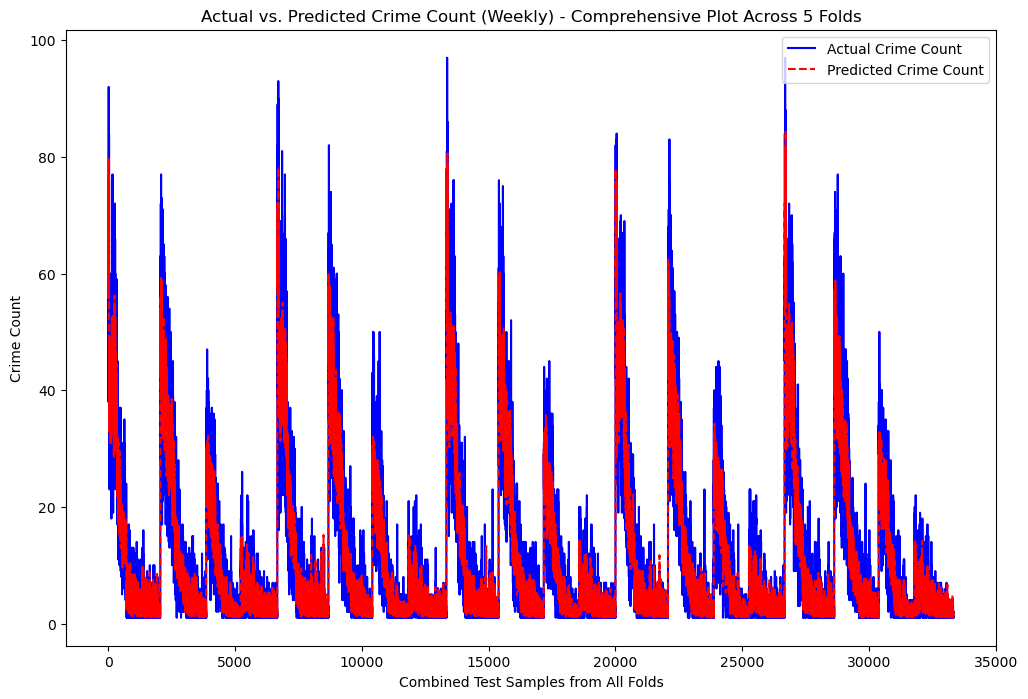

In [103]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(rf_model, X, y)

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 2.5958013282435144
  Root Mean Squared Error (RMSE): 4.359450401159542
  R² Score: 0.8971141576766968



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 2.5941304820315967
  Root Mean Squared Error (RMSE): 4.431130924064588
  R² Score: 0.8982354402542114



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 2.576657363327447
  Root Mean Squared Error (RMSE): 4.319309935608491
  R² Score: 0.9009608030319214



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 2.5824349859510933
  Root Mean Squared Error (RMSE): 4.233474705200084
  R² Score: 0.9048807621002197



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 2.6213048980496594
  Root Mean Squared Error (RMSE): 4.440972214493981
  R² Score: 0.8997926712036133

Average MAE across 5 folds: 2.594065811520662
Average RMSE across 5 folds: 4.356867636105338
Average R² Score across 5 folds: 0.9001967668533325


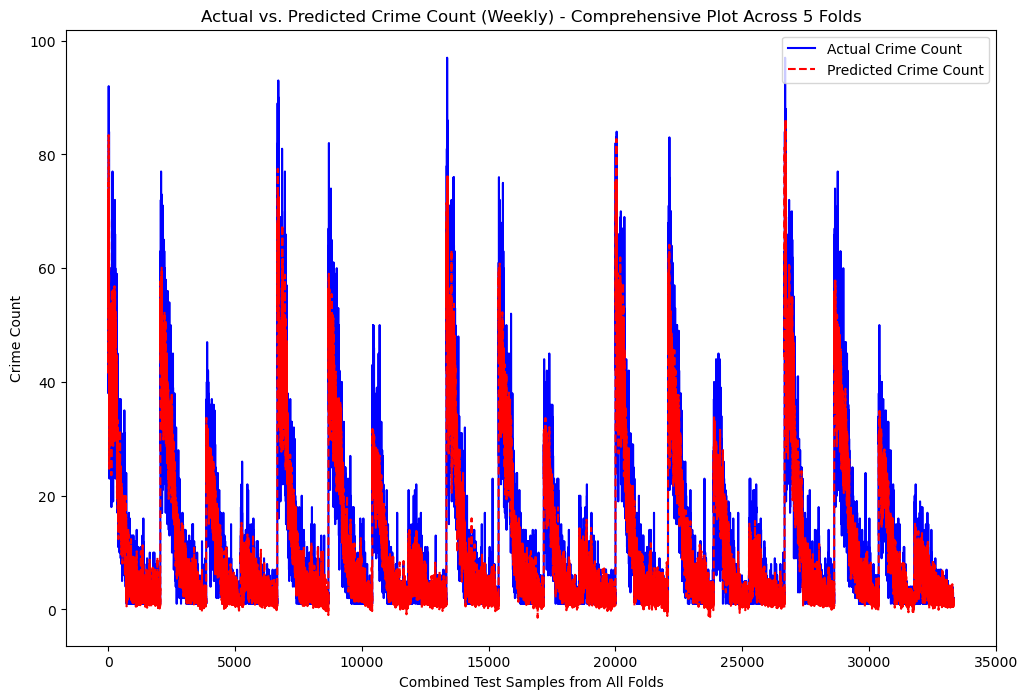

In [104]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(xgb_model, X, y)

In [43]:
crime_time_series = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).agg({
    'dow': 'mean',  
    'hour_of_day': 'mean',
    'extracted_month': 'mean',
    'extracted_day': 'mean',
    'temp_max': 'mean',
    'temp_min': 'mean',
    'daylight_duration': 'mean',
    'precipitation_sum': 'mean',
    'precipitation_hours': 'mean',
    'time_block_numeric': 'mean'
}).reset_index()

crime_time_series['Crime_Count_W'] = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).size().values

# Step 1: Compute the median of weekly crime counts
median_count = crime_time_series['Crime_Count_W'].median()

# Step 2: Create buckets based on the median
crime_time_series['Crime_Count_Bucket'] = np.where(
    crime_time_series['Crime_Count_W'] >= median_count, 1, 0
)

crime_time_series = crime_time_series.sort_values(by='offense_date')

crime_time_series = crime_time_series.drop(columns=['offense_date'])

# Display the updated dataframe
crime_time_series

,census_block_numeric,dow,hour_of_day,extracted_month,extracted_day,temp_max,temp_min,daylight_duration,precipitation_sum,precipitation_hours,time_block_numeric,Crime_Count_W,Crime_Count_Bucket
0,0,3.612903,10.774194,1.000000,3.419355,14.012673,2.872995,33396.085874,0.036132,8.258065,1.225806,62,1
21386,136,3.153846,10.076923,1.000000,2.923077,13.911453,2.356837,33365.294171,0.039067,9.076923,1.538462,13,1
21647,137,3.500000,10.000000,1.000000,2.500000,15.552501,2.637500,33350.941406,0.023622,6.000000,1.000000,2,0
21908,138,2.375000,7.750000,1.000000,3.250000,17.952588,2.697588,33390.614668,0.042815,10.125000,1.750000,8,1
22169,139,5.625000,9.125000,1.000000,4.625000,11.776775,6.106775,33458.826172,0.040354,9.250000,1.250000,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4668,17,6.600000,12.800000,8.700000,21.800000,52.329562,37.047559,33227.744922,0.272047,9.100000,1.900000,10,1
10680,69,4.888889,11.694444,11.694444,28.305556,47.790025,34.150025,33150.052083,0.107174,3.944444,1.444444,36,1
19819,129,5.454545,12.909091,11.000000,26.818182,48.026428,35.038246,33163.135682,0.165712,5.818182,1.000000,11,1
9883,49,3.000000,0.000000,12.000000,27.000000,29.502501,12.942501,33095.019531,0.000000,0.000000,3.000000,1,0


In [47]:
# Count of records in each bucket
bucket_counts = crime_time_series['Crime_Count_Bucket'].value_counts()
print("Bucket Counts:\n", bucket_counts)

# Summary statistics of Crime_Count_W by bucket
bucket_summary = crime_time_series.groupby('Crime_Count_Bucket')['Crime_Count_W'].describe()
print("Bucket Summary Statistics:\n", bucket_summary)

Bucket Counts:
 Crime_Count_Bucket
1    16881
0    16456
Name: count, dtype: int64
Bucket Summary Statistics:
                       count       mean        std  min  25%   50%   75%   max
Crime_Count_Bucket                                                           
0                   16456.0   2.041505   1.071570  1.0  1.0   2.0   3.0   4.0
1                   16881.0  19.338132  15.064714  5.0  7.0  14.0  27.0  97.0


In [63]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Define features for each model component
spatial_features = ['census_block_numeric']
temporal_features = ['dow', 'hour_of_day', 'extracted_month', 'extracted_day', 
                     'temp_max', 'temp_min', 'daylight_duration', 'precipitation_sum', 
                     'precipitation_hours', 'time_block_numeric']

# Scale all features
scaler = MinMaxScaler()
crime_time_series[spatial_features + temporal_features] = scaler.fit_transform(crime_time_series[spatial_features + temporal_features])

# Prepare input (X) and target (y) arrays using the new binary target column
X_spatial = crime_time_series[spatial_features].values
X_temporal = crime_time_series[temporal_features].values
y = crime_time_series['Crime_Count_Bucket'].values  # Use binary bucket target
y = np.array(y)

# Define timesteps based on factor analysis or experiment with values
timesteps = 17

# Ensure all arrays are divisible by `timesteps`
num_samples = (X_temporal.shape[0] // timesteps) * timesteps
X_temporal = X_temporal[:num_samples].reshape((num_samples // timesteps, timesteps, len(temporal_features)))
X_spatial = X_spatial[:num_samples:timesteps]  # Reshape spatial data to align with temporal
y = y[:num_samples:timesteps]  # Align target array with reshaped temporal data

# Verify the shapes of X_temporal, X_spatial, and y are now the same length
print("Shapes after alignment:")
print("X_temporal:", X_temporal.shape)
print("X_spatial:", X_spatial.shape)
print("y:", y.shape)

# Split data chronologically for training and validation
X_temporal_train, X_temporal_val, X_spatial_train, X_spatial_val, y_train, y_val = train_test_split(
    X_temporal, X_spatial, y, test_size=0.2, random_state=42, shuffle=False
)

# Define input shapes for the model
temporal_input_shape = (timesteps, len(temporal_features))
spatial_input_shape = (1, 1, len(spatial_features))  # Spatial data as a single "pixel"

# Create TimeseriesGenerators
train_generator = TimeseriesGenerator(X_temporal_train, y_train, length=timesteps, batch_size=64)
val_generator = TimeseriesGenerator(X_temporal_val, y_val, length=timesteps, batch_size=64)

Shapes after alignment:
X_temporal: (1961, 17, 10)
X_spatial: (1961, 1)
y: (1961,)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Define the model in a function to allow re-instantiation
def create_model(temporal_input_shape, spatial_input_shape, lstm_units=64, gru_units=32, dropout_rate=0.3, learning_rate=0.001):
    temporal_input = Input(shape=temporal_input_shape, name="Temporal_Input")
    x = LSTM(lstm_units, activation='relu', return_sequences=True)(temporal_input)
    x = Dropout(dropout_rate)(x)
    x = GRU(gru_units, activation='relu', return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)

    spatial_input = Input(shape=spatial_input_shape, name="Spatial_Input")
    y = Conv2D(32, (1, 1), activation='relu')(spatial_input)
    y = MaxPooling2D(pool_size=(1, 1))(y)
    y = Flatten()(y)

    combined = concatenate([x, y])
    combined = Dense(16, activation='relu')(combined)
    output = Dense(1, activation='sigmoid', name="Output")(combined)

    model = Model(inputs=[temporal_input, spatial_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
accuracy_scores = []
all_y_val = []
all_y_pred_prob = []

# Hyperparameters to try
lstm_units = 128
gru_units = 64
dropout_rate = 0.2
learning_rate = 0.0003

# Iterate through each fold
for train_index, val_index in kf.split(X_temporal):
    X_temporal_train, X_temporal_val = X_temporal[train_index], X_temporal[val_index]
    X_spatial_train, X_spatial_val = X_spatial[train_index], X_spatial[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model(
        temporal_input_shape=(X_temporal.shape[1], X_temporal.shape[2]), 
        spatial_input_shape=(1, 1, len(spatial_features)),
        lstm_units=lstm_units,
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    history = model.fit(
        [X_temporal_train, X_spatial_train.reshape(-1, 1, 1, 1)],
        y_train,
        validation_data=([X_temporal_val, X_spatial_val.reshape(-1, 1, 1, 1)], y_val),
        epochs=100,
        batch_size=64,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    y_pred_prob = model.predict([X_temporal_val, X_spatial_val.reshape(-1, 1, 1, 1)]).flatten()
    y_pred_classes = (y_pred_prob > 0.5).astype(int)

    # Collect predictions and true values for the combined AUC and confusion matrix
    all_y_val.extend(y_val)
    all_y_pred_prob.extend(y_pred_prob)

    # Rename `auc` variable to avoid conflict with `auc` function
    fold_auc = roc_auc_score(y_val, y_pred_prob)
    accuracy = accuracy_score(y_val, y_pred_classes)
    auc_scores.append(fold_auc)
    accuracy_scores.append(accuracy)

    print(f"Fold AUC: {fold_auc:.4f}, Accuracy: {accuracy:.4f}")

# Display mean and standard deviation of AUC and accuracy across all folds
print(f"\nAverage AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")

# Create the comprehensive ROC curve for all folds combined
fpr, tpr, thresholds = roc_curve(all_y_val, all_y_pred_prob)
combined_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Combined ROC curve (AUC = {combined_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comprehensive ROC Curve for All Folds')
plt.legend(loc="lower right")
plt.show()

# Create and display the confusion matrix for all folds combined
all_y_pred_classes = (np.array(all_y_pred_prob) > 0.5).astype(int)
cm = confusion_matrix(all_y_val, all_y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Crime Bucket", "High Crime Bucket"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Combined Confusion Matrix for All Folds")
plt.show()

Epoch 1/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.6118 - loss: 0.6674 - val_accuracy: 0.6389 - val_loss: 0.6408
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6446 - loss: 0.6411 - val_accuracy: 0.6496 - val_loss: 0.6313
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.6469 - loss: 0.6403 - val_accuracy: 0.6523 - val_loss: 0.6278
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6592 - loss: 0.6323 - val_accuracy: 0.6569 - val_loss: 0.6272
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6651 - loss: 0.6285 - val_accuracy: 0.6499 - val_loss: 0.6332
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6601 - loss: 0.6329 - val_accuracy: 0.6658 - val_loss: 0.6250
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6658 - loss: 0.6274 - val_accuracy: 0.6667 - val_loss: 0.6252
Epoch 8/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6616 - loss: 0.6311 -

In [69]:
crime_time_series = crime.groupby(['census_block_numeric', pd.Grouper(freq='D')]).agg({
    'dow': 'first',  
    'hour_of_day': 'first',
    'extracted_month': 'first',
    'extracted_day': 'first',
    'temp_max': 'first',
    'temp_min': 'first',
    'daylight_duration': 'first',
    'precipitation_sum': 'first',
    'precipitation_hours': 'first',
    'time_block_numeric': 'first'
}).reset_index()

crime_time_series['Crime_Count_D'] = crime.groupby(['census_block_numeric', pd.Grouper(freq='D')]).size().values

# Step 1: Compute the median of weekly crime counts
median_count = crime_time_series['Crime_Count_D'].median()

# Step 2: Create buckets based on the median
crime_time_series['Crime_Count_Bucket'] = np.where(
    crime_time_series['Crime_Count_D'] >= median_count, 1, 0
)

crime_time_series = crime_time_series.sort_values(by='offense_date')

crime_time_series = crime_time_series.drop(columns=['offense_date'])

# Display the updated dataframe
crime_time_series

,census_block_numeric,dow,hour_of_day,extracted_month,extracted_day,temp_max,temp_min,daylight_duration,precipitation_sum,precipitation_hours,time_block_numeric,Crime_Count_D,Crime_Count_Bucket
0,0,2,17,1,1,11.570000,0.139999,33280.367188,0.051181,12.0,0,19,1
42711,71,2,0,1,1,11.827398,0.397396,33280.367188,0.051181,12.0,3,17,1
40901,70,2,0,1,1,12.878599,2.258602,33253.820312,0.082677,18.0,3,9,1
90102,138,2,9,1,1,14.008101,4.918100,33253.820312,0.082677,20.0,2,3,1
70201,94,2,15,1,1,11.897600,0.467596,33280.367188,0.051181,12.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19134,10,7,20,1,1,45.700000,35.100000,33211.740000,0.035000,7.0,1,1,0
59190,80,7,19,1,1,49.820000,35.689999,33264.988281,0.007874,2.0,1,2,1
101804,190,7,21,1,1,50.147598,36.017601,33264.988281,0.007874,2.0,1,2,1
44512,71,7,21,1,1,49.139603,34.109600,33264.988281,0.011811,3.0,1,1,0


In [71]:
# Count of records in each bucket
bucket_counts = crime_time_series['Crime_Count_Bucket'].value_counts()
print("Bucket Counts:\n", bucket_counts)

# Summary statistics of Crime_Count_W by bucket
bucket_summary = crime_time_series.groupby('Crime_Count_Bucket')['Crime_Count_D'].describe()
print("Bucket Summary Statistics:\n", bucket_summary)

Bucket Counts:
 Crime_Count_Bucket
1    73663
0    41205
Name: count, dtype: int64
Bucket Summary Statistics:
                       count     mean       std  min  25%  50%  75%   max
Crime_Count_Bucket                                                      
0                   41205.0  1.00000  0.000000  1.0  1.0  1.0  1.0   1.0
1                   73663.0  4.32832  2.741352  2.0  2.0  3.0  6.0  33.0


In [74]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Define features for each model component
spatial_features = ['census_block_numeric']
temporal_features = ['dow', 'hour_of_day', 'extracted_month', 'extracted_day', 
                     'temp_max', 'temp_min', 'daylight_duration', 'precipitation_sum', 
                     'precipitation_hours', 'time_block_numeric']

# Scale all features
scaler = MinMaxScaler()
crime_time_series[spatial_features + temporal_features] = scaler.fit_transform(crime_time_series[spatial_features + temporal_features])

# Prepare input (X) and target (y) arrays using the new binary target column
X_spatial = crime_time_series[spatial_features].values
X_temporal = crime_time_series[temporal_features].values
y = crime_time_series['Crime_Count_Bucket'].values  # Use binary bucket target
y = np.array(y)

# Define timesteps based on factor analysis or experiment with values
timesteps = 7

# Ensure all arrays are divisible by `timesteps`
num_samples = (X_temporal.shape[0] // timesteps) * timesteps
X_temporal = X_temporal[:num_samples].reshape((num_samples // timesteps, timesteps, len(temporal_features)))
X_spatial = X_spatial[:num_samples:timesteps]  # Reshape spatial data to align with temporal
y = y[:num_samples:timesteps]  # Align target array with reshaped temporal data

# Verify the shapes of X_temporal, X_spatial, and y are now the same length
print("Shapes after alignment:")
print("X_temporal:", X_temporal.shape)
print("X_spatial:", X_spatial.shape)
print("y:", y.shape)

# Split data chronologically for training and validation
X_temporal_train, X_temporal_val, X_spatial_train, X_spatial_val, y_train, y_val = train_test_split(
    X_temporal, X_spatial, y, test_size=0.2, random_state=42, shuffle=False
)

# Define input shapes for the model
temporal_input_shape = (timesteps, len(temporal_features))
spatial_input_shape = (1, 1, len(spatial_features))  # Spatial data as a single "pixel"

# Create TimeseriesGenerators
train_generator = TimeseriesGenerator(X_temporal_train, y_train, length=timesteps, batch_size=64)
val_generator = TimeseriesGenerator(X_temporal_val, y_val, length=timesteps, batch_size=64)

Shapes after alignment:
X_temporal: (16409, 7, 10)
X_spatial: (16409, 1)
y: (16409,)


Epoch 1/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6327 - loss: 0.6644 - val_accuracy: 0.6380 - val_loss: 0.6387
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6437 - loss: 0.6365 - val_accuracy: 0.6627 - val_loss: 0.6283
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6621 - loss: 0.6314 - val_accuracy: 0.6630 - val_loss: 0.6254
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6690 - loss: 0.6276 - val_accuracy: 0.6676 - val_loss: 0.6253
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6631 - loss: 0.6283 - val_accuracy: 0.6709 - val_loss: 0.6260
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6714 - loss: 0.6255 - val_accuracy: 0.6712 - val_loss: 0.6257
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6670 - loss: 0.6314 - val_accuracy: 0.6670 - val_loss: 0.6244
Epoch 8/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6709 - loss: 0.6278 - 

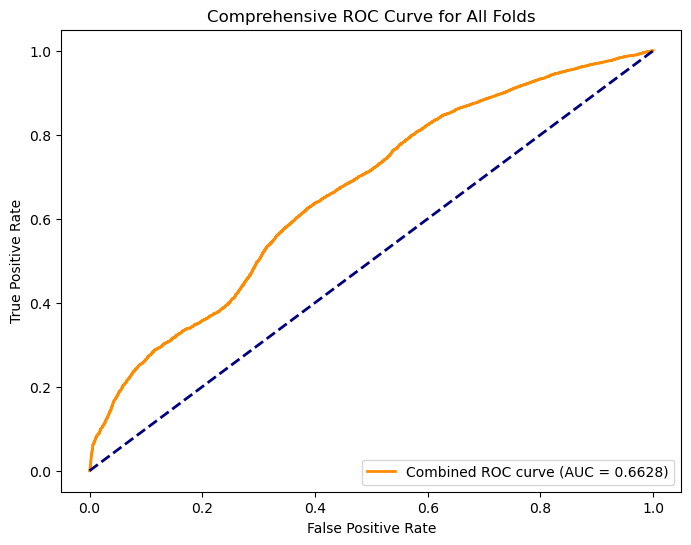

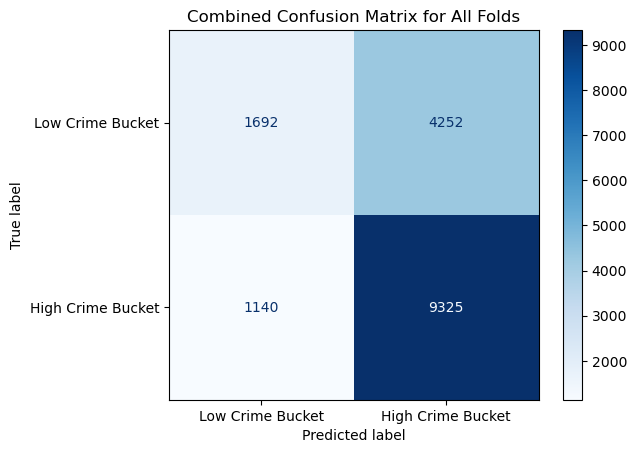

In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Define the model in a function to allow re-instantiation
def create_model(temporal_input_shape, spatial_input_shape, lstm_units=64, gru_units=32, dropout_rate=0.3, learning_rate=0.001):
    temporal_input = Input(shape=temporal_input_shape, name="Temporal_Input")
    x = LSTM(lstm_units, activation='relu', return_sequences=True)(temporal_input)
    x = Dropout(dropout_rate)(x)
    x = GRU(gru_units, activation='relu', return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)

    spatial_input = Input(shape=spatial_input_shape, name="Spatial_Input")
    y = Conv2D(32, (1, 1), activation='relu')(spatial_input)
    y = MaxPooling2D(pool_size=(1, 1))(y)
    y = Flatten()(y)

    combined = concatenate([x, y])
    combined = Dense(16, activation='relu')(combined)
    output = Dense(1, activation='sigmoid', name="Output")(combined)

    model = Model(inputs=[temporal_input, spatial_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
accuracy_scores = []
all_y_val = []
all_y_pred_prob = []

# Hyperparameters to try
lstm_units = 128
gru_units = 64
dropout_rate = 0.2
learning_rate = 0.0005

# Iterate through each fold
for train_index, val_index in kf.split(X_temporal):
    X_temporal_train, X_temporal_val = X_temporal[train_index], X_temporal[val_index]
    X_spatial_train, X_spatial_val = X_spatial[train_index], X_spatial[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model(
        temporal_input_shape=(X_temporal.shape[1], X_temporal.shape[2]), 
        spatial_input_shape=(1, 1, len(spatial_features)),
        lstm_units=lstm_units,
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    history = model.fit(
        [X_temporal_train, X_spatial_train.reshape(-1, 1, 1, 1)],
        y_train,
        validation_data=([X_temporal_val, X_spatial_val.reshape(-1, 1, 1, 1)], y_val),
        epochs=100,
        batch_size=64,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    y_pred_prob = model.predict([X_temporal_val, X_spatial_val.reshape(-1, 1, 1, 1)]).flatten()
    y_pred_classes = (y_pred_prob > 0.5).astype(int)

    # Collect predictions and true values for the combined AUC and confusion matrix
    all_y_val.extend(y_val)
    all_y_pred_prob.extend(y_pred_prob)

    # Rename `auc` variable to avoid conflict with `auc` function
    fold_auc = roc_auc_score(y_val, y_pred_prob)
    accuracy = accuracy_score(y_val, y_pred_classes)
    auc_scores.append(fold_auc)
    accuracy_scores.append(accuracy)

    print(f"Fold AUC: {fold_auc:.4f}, Accuracy: {accuracy:.4f}")

# Display mean and standard deviation of AUC and accuracy across all folds
print(f"\nAverage AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")

# Create the comprehensive ROC curve for all folds combined
fpr, tpr, thresholds = roc_curve(all_y_val, all_y_pred_prob)
combined_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Combined ROC curve (AUC = {combined_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comprehensive ROC Curve for All Folds')
plt.legend(loc="lower right")
plt.show()

# Create and display the confusion matrix for all folds combined
all_y_pred_classes = (np.array(all_y_pred_prob) > 0.5).astype(int)
cm = confusion_matrix(all_y_val, all_y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Crime Bucket", "High Crime Bucket"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Combined Confusion Matrix for All Folds")
plt.show()